In [1]:
SEED = 42
import os
os.environ['PYTHONHASHSEED']=str(SEED)
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

def reset_seeds():
    np.random.seed(SEED) # Establecer la semilla para el generador de números aleatorios de Numpy
    tf.random.set_seed(SEED) # Establecer la semilla para el generador de números aleatorios de TensorFlow
    random.seed(SEED) # Establecer la semilla para el generador de números aleatorios de Python

reset_seeds()

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Ruta al directorio del conjunto de datos de validación
train_loc = './OfficialSpectrogramsMelAUG/train'
test_loc = './OfficialSpectrogramsMelAUG/test'

# Definir la normalización
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Crear los generadores de datos
train_generator = train_datagen.flow_from_directory(
    directory=train_loc,
    target_size=(224,224),
    shuffle=True,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    directory=test_loc,
    target_size=(224,224),
    shuffle=False,
    seed=SEED
)

def generator_fn():
    for x_batch, y_batch in test_generator:
        yield x_batch, y_batch

# Crear el dataset a partir del generador
test_dataset = tf.data.Dataset.from_generator(
    generator_fn,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, len(test_generator.class_indices)])
)

# Configurar el dataset para evaluación
steps_per_epoch = test_generator.samples // test_generator.batch_size
if test_generator.samples % test_generator.batch_size != 0:
    steps_per_epoch += 1
    
test_dataset = test_dataset.take(steps_per_epoch) \
                           .cache() \
                           .prefetch(buffer_size=tf.data.AUTOTUNE)

# Cargar el modelo guardado
model = load_model('./Best_Models/Tests/Adam/RN152V2_Adam_00005.h5')

loss, accuracy = model.evaluate(test_dataset) 
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9
Found 8544 images belonging to 4 classes.
Found 2756 images belonging to 4 classes.
87/87 [==============================] - 18s 137ms/step - loss: 1.5893 - accuracy: 0.5595
Validation loss: 1.5893080234527588
Validation accuracy: 0.5595065355300903


In [2]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predicciones en el conjunto de prueba
predictions = model.predict(test_generator)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(predictions)]

# Convertir las predicciones en etiquetas de clase
y_pred_classes = np.argmax(predictions, axis=1)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Obtener el número total de predicciones correctas para cada clase
Pc = sum((y_true == 0) & (y_pred_classes == 0))  # Crackle
Pb = sum((y_true == 1) & (y_pred_classes == 1))  # Both
Pn = sum((y_true == 2) & (y_pred_classes == 2))  # Normal
Pw = sum((y_true == 3) & (y_pred_classes == 3))  # Wheeze

# Obtener el total de muestras para cada clase
Crackle_total = sum(y_true == 0)  # Total de muestras de la clase Crackle
Both_total = sum(y_true == 1)     # Total de muestras de la clase Both
Normal_total = sum(y_true == 2)   # Total de muestras de la clase Normal
Wheeze_total = sum(y_true == 3)   # Total de muestras de la clase Wheeze

# Calcular el puntaje Se (Sensibilidad)
Se = (Pc + Pw + Pb) / (Crackle_total + Wheeze_total + Both_total)

# Calcular el puntaje Sp (Especificidad)
Sp = Pn / Normal_total

# Calcular el puntaje promedio
score = (Se + Sp) / 2

# Mostrar los resultados
print("Puntaje de Sensibilidad (Se):", Se)
print("Puntaje de Especificidad (Sp):", Sp)
print("Puntaje promedio:", score)

87/87 [==============================] - 14s 134ms/step
Accuracy: 0.5595065312046444
Precision: 0.5566244173767557
Recall: 0.5595065312046444
F1 Score: 0.5566104745799374
Puntaje de Sensibilidad (Se): 0.41206457094307564
Puntaje de Especificidad (Sp): 0.6694110196326789
Puntaje promedio: 0.5407377952878772


In [3]:
# Mostrar el informe de clasificación
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

Class names: ['crackle', 'crackle_wheeze', 'normal', 'wheeze']
Classification Report:
                precision    recall  f1-score   support

       crackle       0.46      0.52      0.49       649
crackle_wheeze       0.27      0.15      0.19       143
        normal       0.68      0.67      0.67      1579
        wheeze       0.32      0.32      0.32       385

      accuracy                           0.56      2756
     macro avg       0.43      0.42      0.42      2756
  weighted avg       0.56      0.56      0.56      2756



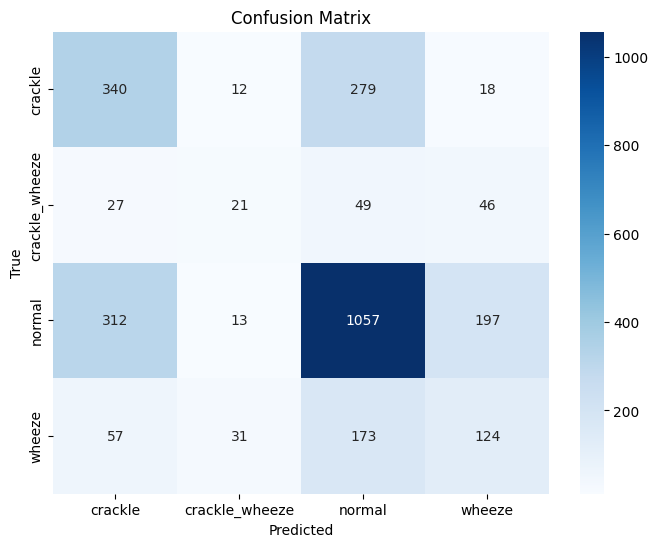

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para mostrar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Calcular y mostrar la matriz de confusión
plot_confusion_matrix(y_true, y_pred_classes, class_names)